# This notebook connects into our instace of PostgreSQL running on a container, in order to answer the following questions, using Python:
* What's the latest temperature for all of the geo locations? What's the latest wind speed? 

* Show an hourly time series of temperature (or any other available weather variable) from a day ago to 5 days in the future for a selected location

First step is retrieving configs for the connection:

In [ ]:
import psycopg2
from datetime import datetime, timedelta
import pandas as pd
import matplotlib
import configparser

def load_config(file_path: str) -> dict:
    """
    Load configuration from file.
    """
    config = configparser.ConfigParser()
    config.read(file_path)
    return config._sections

file_config = load_config('notebook.config')

postgres_user = file_config['Postgresql']['postgres_user']
postgres_password = file_config['Postgresql']['postgres_password']
postgres_database = file_config['Postgresql']['postgres_db']


# PostgreSQL connection parameters
connection_params = {
    "host": "localhost",
    "port": "5432",
    "database": postgres_database,
    "user": postgres_user,
    "password": postgres_password
}

We define the functions that query our PostgreSQL database

In [59]:

def get_latest_weather_data():
    """Retrieve the latest weather data for all geo locations."""
    try:
        connection = psycopg2.connect(**connection_params)

        query = """
        WITH latest_prediction AS (
            SELECT 
                lat,
                lon,
                max(predictiontime) as latest_prediction_time
            FROM
                tomorrowio.forecasts
            GROUP BY
                lat,
                lon
        )
        SELECT 
            lat, 
            lon, 
            predictiontime, 
            temperature, 
            windspeed
        FROM tomorrowio.forecasts 
        WHERE predictiontime in (select latest_prediction_time from latest_prediction)
        """
        
        with connection.cursor() as cursor:
            cursor.execute(query)
            latest_data = cursor.fetchall()
        df_latest_data = pd.DataFrame(latest_data, columns=["lat", "lon", "predictiontime", "temperature", "windspeed"])
        return df_latest_data

    except (Exception, psycopg2.Error) as error:
        print(f"Error retrieving latest weather data: {error}")
    finally:
        if connection:
            connection.close()


In [61]:
def get_hourly_time_series(lat, lon, variable):
    """Retrieve hourly time series data for a selected location and weather variable."""
    now = datetime.now().date().strftime("%Y-%m-%d %H:%M:%S")
    yesterday = (datetime.now().date()+timedelta(days=-1)).strftime("%Y-%m-%d %H:%M:%S")
    five_days_in_the_future = (datetime.now()+timedelta(days=5)).strftime("%Y-%m-%d %H:%M:%S")
    try:
        # Connect to the PostgreSQL database
        connection = psycopg2.connect(**connection_params)

        # Define the SQL query
        query = f"""
        SELECT predictiontime, {variable}
        FROM tomorrowio.forecasts
        WHERE lat = '{lat}' AND lon = '{lon}' AND predictiontime >= '{now}' AND predictiontime <= '{five_days_in_the_future}'
        UNION
        SELECT historicaltime as predictiontime, {variable}
        FROM tomorrowio.recent_weather_history
        WHERE lat = '{lat}' AND lon = '{lon}' AND historicaltime >= '{yesterday}'

        ORDER BY predictiontime ASC
        """

        # Execute the query and fetch the results
        with connection.cursor() as cursor:
            cursor.execute(query)
            time_series_data = cursor.fetchall()
        df_time_series = pd.DataFrame(time_series_data, columns=["predictiontime", variable])
        return df_time_series

    except (Exception, psycopg2.Error) as error:
        print(f"Error retrieving hourly time series data: {error}")
    finally:
        # Close the database connection
        if connection:
            connection.close()

In [ ]:
get_latest_weather_data()

In [62]:
df_time_series = get_hourly_time_series('25.86','-97.42','temperature')
df_time_series

,predictiontime,temperature
0,2024-04-06 14:00:00,23.69
1,2024-04-06 15:00:00,25.00
2,2024-04-06 16:00:00,25.88
3,2024-04-06 17:00:00,26.69
4,2024-04-06 18:00:00,27.38
...,...,...
95,2024-04-10 13:00:00,23.67
96,2024-04-10 14:00:00,24.25
97,2024-04-10 15:00:00,26.01
98,2024-04-10 16:00:00,28.10


<Axes: xlabel='predictiontime'>

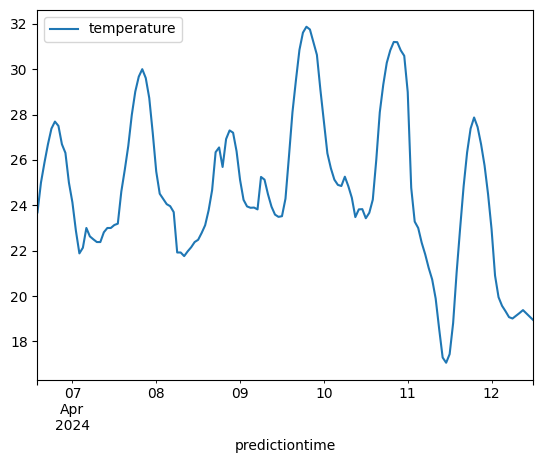

In [63]:
df_time_series.plot(x='predictiontime',y='temperature')